# Feature Extraction

Tranfer learning is leveraging a working model's existing architecture and learned patterns for our own benefits

There are two main benefits:
- Can leverage an existing neural network architecture proven to work on problems similar to our own
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adopt those patterns to our own data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("Data//10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Data//10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data//10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'Data//10_food_classes_10_percent\test\steak'.
The

## Creating data loaders (preparing the data)

We'll use `ImageDataGenerator` class to load in our images in batches

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "Data/10_food_classes_10_percent/train/"
test_dir = "Data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size = IMG_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = "categorical")

print("Testing images:")
test_data= test_datagen.flow_from_directory(test_dir,
                                           target_size = IMG_SHAPE,
                                           batch_size = BATCH_SIZE,
                                           class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks

* Tracking experiments with TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# Creating models using TensorFlow Hub

In [5]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1"

efficientnet_google_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
    model_url (str): A TensorFlow Hub features extraction URL.
    num_classes (int): Number of output neuroons in the output layer,
        should be equal to number target_classes, default 10.

    Returns:
        A uncompiled Keras Sequential model with model_url as features extractor
        layer and Dense output layer with nun_classes output neurons.
    """
    # Download the pretrained model and it as Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable = False,  # freeze the already patterns
                                            name = "feature_extraction_layer",
                                            input_shape = (224, 224, 3))

    # create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [8]:
train_data_10_percent.num_classes

10

In [9]:
resnet_model = create_model(resnet_url,
                           num_classes = train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              44677609  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [11]:
# Compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [12]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       experiment_name="resnet50v2"
                                                                       )])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/231118-225618
Epoch 1/5
24/24 [==============================] - 88113s 3831s/step - loss: 2.2977 - accuracy: 0.3520 - val_loss: 1.2049 - val_accuracy: 0.6056
Epoch 2/5
24/24 [==============================] - 226s 10s/step - loss: 0.9331 - accuracy: 0.7000 - val_loss: 0.8656 - val_accuracy: 0.7100
Epoch 3/5
24/24 [==============================] - 221s 10s/step - loss: 0.6635 - accuracy: 0.7893 - val_loss: 0.8014 - val_accuracy: 0.7360
Epoch 4/5
24/24 [==============================] - 221s 9s/step - loss: 0.5185 - accuracy: 0.8467 - val_loss: 0.7564 - val_accuracy: 0.7448
Epoch 5/5
24/24 [==============================] - 226s 10s/step - loss: 0.4181 - accuracy: 0.8867 - val_loss: 0.7530 - val_accuracy: 0.7484


In [13]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: Tensorflow History object.

    Returns:
        Plot of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    #plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

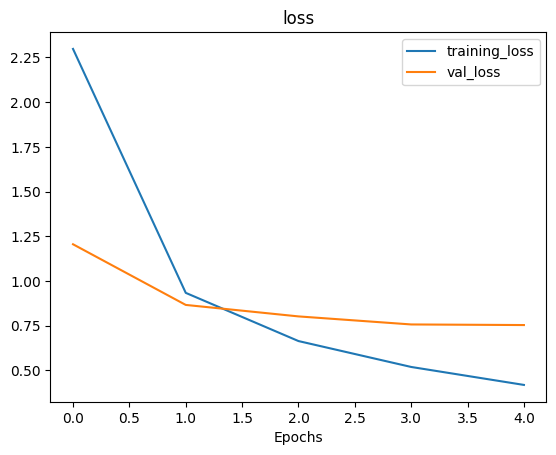

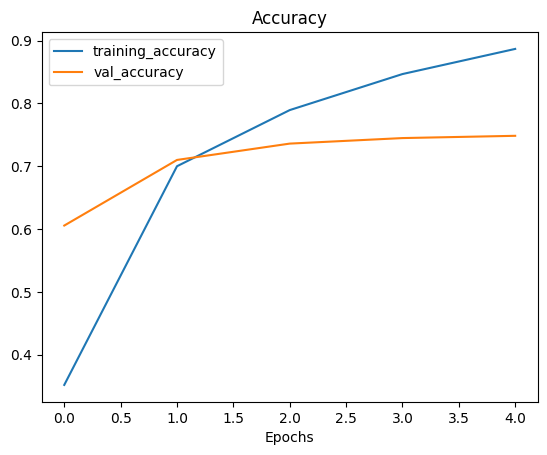

In [14]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNet TensorFlow Hub Feature Extraction model

In [15]:
# Create EfficientNetB0 feature model 
efficientnet_model = create_model(model_url=efficientnet_url,
                                 num_classes= train_data_10_percent.num_classes)

# Compile Efficient model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ["accuracy"])
# Fit Efficient model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data,
                                             validation_steps=len(test_data),
                                             callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                    experiment_name="efficientnetb0"
                                                                                   )])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/231119-233955
Epoch 1/5
24/24 [==============================] - 97s 4s/step - loss: 2.2937 - accuracy: 0.1347 - val_loss: 2.2844 - val_accuracy: 0.3084
Epoch 2/5
24/24 [==============================] - 83s 4s/step - loss: 2.2785 - accuracy: 0.4027 - val_loss: 2.2693 - val_accuracy: 0.5060
Epoch 3/5
24/24 [==============================] - 84s 4s/step - loss: 2.2643 - accuracy: 0.5133 - val_loss: 2.2546 - val_accuracy: 0.5616
Epoch 4/5
24/24 [==============================] - 82s 4s/step - loss: 2.2502 - accuracy: 0.5667 - val_loss: 2.2397 - val_accuracy: 0.5932
Epoch 5/5
24/24 [==============================] - 82s 4s/step - loss: 2.2356 - accuracy: 0.5920 - val_loss: 2.2250 - val_accuracy: 0.6092


In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              5330564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5340574 (20.37 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


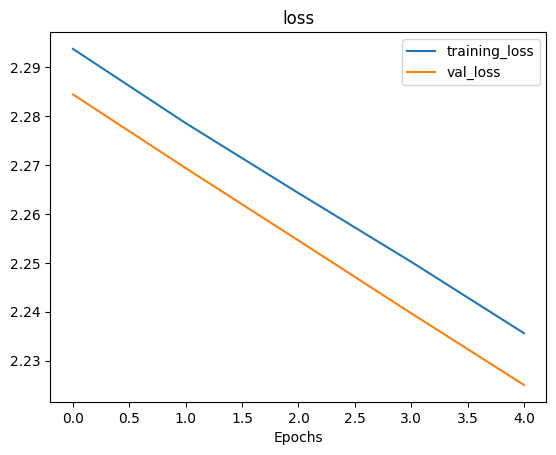

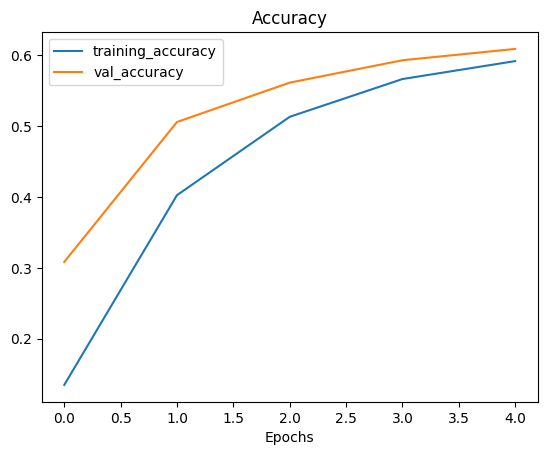

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
len(efficientnet_model.layers[0].weights)

311

## Creating and testing EfficientNet Google TensorFlow Hub Feature Extraction model

In [19]:
# Create EfficientNet google feature model 
efficientnet_google_model = create_model(model_url=efficientnet_google_url,
                                 num_classes= train_data_10_percent.num_classes)

# Compile Efficient google model
efficientnet_google_model.compile(loss="categorical_crossentropy",
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ["accuracy"])

# Fit Efficient google model to 10% of training data
efficientnet_google_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data,
                                             validation_steps=len(test_data),
                                             callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                    experiment_name="efficientnet_google"
                                                                                   )])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_google/231119-234707
Epoch 1/5
24/24 [==============================] - 83s 4s/step - loss: 2.2218 - accuracy: 0.6067 - val_loss: 2.2106 - val_accuracy: 0.6252
Epoch 2/5
24/24 [==============================] - 82s 4s/step - loss: 2.2077 - accuracy: 0.6187 - val_loss: 2.1964 - val_accuracy: 0.6376
Epoch 3/5
24/24 [==============================] - 82s 4s/step - loss: 2.1937 - accuracy: 0.6253 - val_loss: 2.1822 - val_accuracy: 0.6432
Epoch 4/5
24/24 [==============================] - 82s 4s/step - loss: 2.1800 - accuracy: 0.6307 - val_loss: 2.1681 - val_accuracy: 0.6452
Epoch 5/5
24/24 [==============================] - 83s 4s/step - loss: 2.1665 - accuracy: 0.6360 - val_loss: 2.1541 - val_accuracy: 0.6500


efficientnet_google_model.summary()

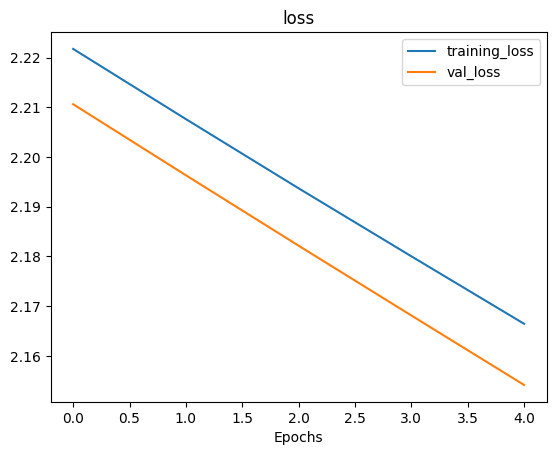

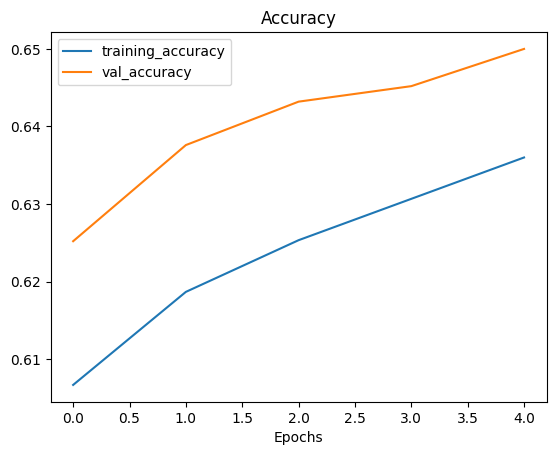

In [21]:
plot_loss_curves(efficientnet_google_history)

In [22]:
len(efficientnet_google_model.layers[0].weights)

361

## Different types of tranfer learning
- **"As is" tranfer learning** - using an existing model with no changes what so ever(e.g. using ImageNet model 1000 ImageNet classes, none of your own)
- **"Feature Extraction" transfer learning** - use the prelearned patterns of an existing model(e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for layer for own problem(e.g. 1000 classes -> 10 classes of food)
- **"Fine-tuning" tranfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)